[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RikVoorhaar/optimization-II-2021/blob/master/notebooks/week14.ipynb)

# Exam project

This is the Python programming homework  that counts for the exam of this course. This homework will require a little bit more independence from you, and you will need to write more code fully by yourself than for other homework. Furthermore there are no automatic tests, so you need to verify yourself that your solution is correct.

As usual, you can do this homework either on Google colab, or on your own machine (after installing conda). 

We begin by running the cell below. If you're running this notebook on a local python installation, make sure that this cell does not throw any errors. If it does, you will need to install additional packages. You can do this by using `pip` from the command line.

In [ ]:
from importlib_metadata import version

import cvxpy as cp
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = (9, 6)
import numpy as np
import pandas as pd
import scipy

import warnings

warnings.filterwarnings("ignore")  # don't display irrelevant deprecation warnings

## Part 1: Alternating projection algorithm

Most solvers of convex problems $\min_{x\in\Omega}f(x)$ always start by first finding a feasible point $x\in \Omega$. For some constraint sets this step can be very difficult, but if $\Omega$ is the intersection of several simple constraints then we can use a relatively simple method to find a feasible point. 

Suppose that $\Omega = C_1\cap\dots\cap C_k\subset \mathbb R^n$, with each $C_i\subset \mathbb R^n$ closed convex, and such that we have a projection map $P_{C_i}\colon \mathbb R^n\to C_i$. Recall that $P_{C_i}(x)$ returns the point $y \in C_i$ that is closest to $x$ in Euclidean norm. Then starting with some $x_0$ we could naively set $x = P_{C_k}\dots P_{C_2}P_{C_1}x_0$ and expect that $x\in \Omega$. This is unfortunately not the case, but we can iterate this procedure, that is, we can set 
$$
x_{i+1} = P_{C_k}\dots P_{C_2}P_{C_1}x_i, \qquad i=0,1, \ldots.
$$

This iterative procedure is known as the  [Alternating projection algorithm](https://en.wikipedia.org/wiki/Projections_onto_convex_sets), also known as _projection onto convex sets (POCS)_. 

One can prove that, as long as $\Omega\neq\emptyset$, then the iterates $(x_i)$ produced by the _alternating projection algorithm_ converge linearly to a point in $x\in\Omega$. Note that this point $x$ is not necessarily the projection of $x_0$ onto $\Omega$, nor does the algoritm necessarily give a point in $\Omega$ in a finite number of steps (hence I think that "projection onto convex sets" is a bit of misnomer). Nevertheless, for the purpose of finding a feasible point for a convex solver this is good enough: As long as $x$ satisfies the constraints up to some small error on the order of the machine epsilon, we can consider $x$ to lie in $\Omega$ from a numerical point of view.

### Exercise 1a) Finding a point in a polyhedron

Recall that a convex polyhedron is given by a set of inequalities of the form $C_i=\{x\in\mathbb R^n\mid a_i^\top x\leq b_i\}$ for a vector $a_i\in\mathbb R^n$ and $b_i\in \mathbb R$, or encoded as a matrix $\Omega = \{x\in\mathbb R^n\mid Ax\leq b\}$ for some matrix $A$ and vector $b$. Each convex set $C_i$ is a halfspace, and we can project onto it by setting
$$
    P_{C_i}(x) = \begin{cases}x &\text{if } a_i^\top x\leq b_i\\ x-(a_i^\top x-b_i){a_i}/{\|a_i\|^2} & \text{if } a_i^\top x> b_i\end{cases}
$$

---

> Implement the alternating projection algorithm for finding a point in a polyhedron. As input you should accept any $m\times n$ matrix `A` and length $m$ vector `b`. 

> Do at most `max_its` iterations. Sometimes the algorithm will return a point inside the polyhedron in a finite number of steps, or sometimes it will converge to a point very close to the polyhedron (a distance on the order of $10^{-16}$). Try to detect this convergence, and if so make the algorithm stop early (i.e. in less than `max_its` iterations).

---

To generate test problems, we need to generate random polytopes in arbitrary dimensions. The simplest way to do this is to compute the convex hull of a random set of points. For this we can use the `scipy` routine [scipy.spatial.ConvexHull](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html), which is a Python interface to the C++ library [Qhull](http://www.qhull.org/). 

- Computing the convex hull in high dimension can be very expensive. Only run the code `random_polytope` for values of `n_dim` until  10.


In [ ]:
def random_polytope(n_dims, n_points=None):
    """Generate a random polytope by taking convex hull of random points"""
    from scipy.spatial import ConvexHull

    if n_points is None:  # Number of points in the convex hull
        n_points = n_dims * 2 + 10
    points = np.random.normal(size=(n_points, n_dims))
    shift = np.random.uniform(
        -100, 100, size=n_dims
    )  # Shift the points so 0 isn't a feasible point
    points += shift

    # Find the convex hull, and extract the hyperplane constraints
    hull = ConvexHull(points)
    A = hull.equations[:, :-1]
    b = -hull.equations[:, -1]
    return A, b, hull

def plot_hull_2D(hull):
    """Plot a 2d convex hull"""
    points = hull.points
    for n1, n2 in hull.simplices:
        v1 = points[n1]
        v2 = points[n2]
        plt.plot([v1[0], v2[0]], [v1[1], v2[1]], c="k")
        plt.plot(points[hull.vertices, 0], points[hull.vertices, 1], "or")

Iteration number:  1
Boolean of conditions: [[ True]
 [False]
 [ True]
 [False]
 [ True]]
Iteration number:  2
Boolean of conditions: [[ True]
 [False]
 [ True]
 [ True]
 [ True]]
Iteration number:  3
Boolean of conditions: [[ True]
 [ True]
 [False]
 [False]
 [False]]
Iteration number:  4
Boolean of conditions: [[ True]
 [False]
 [ True]
 [False]
 [ True]]
Iteration number:  5
Boolean of conditions: [[ True]
 [False]
 [ True]
 [ True]
 [ True]]
Iteration number:  6
Boolean of conditions: [[ True]
 [ True]
 [False]
 [False]
 [False]]
Iteration number:  7
Boolean of conditions: [[ True]
 [False]
 [ True]
 [False]
 [ True]]
Iteration number:  8
Boolean of conditions: [[ True]
 [False]
 [ True]
 [ True]
 [ True]]
Iteration number:  9
Boolean of conditions: [[ True]
 [ True]
 [False]
 [False]
 [False]]
Iteration number:  10
Boolean of conditions: [[ True]
 [False]
 [ True]
 [False]
 [False]]
Iteration number:  11
Boolean of conditions: [[ True]
 [False]
 [ True]
 [False]
 [False]]
Iteratio

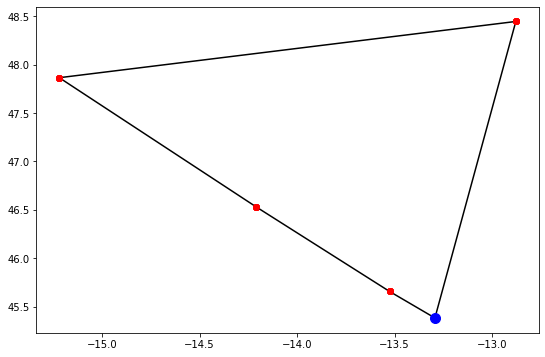

In [ ]:
from numpy.linalg import norm

def alternating_projection_polyhedron(A, b, max_its=100):
    """
    Compute a feasible point in the polyhedron A@x<=b using alternating
    projection algorithm.
    Use a maximum of `max_its` iterations. Stop early when converge is reached.
    """

    # case where n=1 and/or m =1
    if len(np.shape(A)) ==0 and len(np.shape(b)) ==0 and A ==0:
        return b
    elif len(np.shape(A)) ==0 and len(np.shape(b)) ==0 and A !=0:
        return b/A
    elif (len(np.shape(A)) ==0 and len(np.shape(b)) !=0) or (len(np.shape(A)) !=0 and len(np.shape(b)) ==0):
        print('There is a problem of dimension between A and b')
        return None 
    
    # case of no match in dimensions
    if not  np.shape(b)[0] == np.shape(A)[0]:
        print('There is a problem of dimension between A and b')
        return None
    
    n = np.shape(A)[1] # number of conditions
    m = np.shape(A)[0] # dimension
    
    #initialization
    nb_iter = 0
    eps = 10**-16 
    x =  np.random.normal(size=(n,1)) # initialization of x with a random numbers
    
    #compute boolean of conditions
    polyhe_cond = np.dot(A,x)-eps <=b.reshape(m,1)
    
    while not(all(polyhe_cond)) and nb_iter<max_its :
        nb_iter += 1
        print('Iteration number: ',nb_iter)
        
        #for each component that does not meet the condition
        for i in np.where(polyhe_cond==0)[0]:
            ai = A[i,:]
            temp = ((np.dot(ai,x)-b[i])*ai.T)/(norm(ai)**2)
            x -=  temp.reshape(n,1)
        
        #uptade boolean of conditions  
        polyhe_cond = np.dot(A,x)-eps <=b.reshape(m,1)
        print('Boolean of conditions:',polyhe_cond)
    return x


# Generate random polytope, and plot if 2D
# You should `dim` to other values, and see if it still works
# Don't put `dim` higher than ~10, since then the convex hull
# takes long to compute.
dim = 2
A, b, hull = random_polytope(dim)
if dim == 2:
    plot_hull_2D(hull)

x = alternating_projection_polyhedron(A, b)

plt.plot([x[0]], [x[1]], "ob", markersize=10);

### Exercise 1b): Feasible point for SDP constraints

Recall that SDP constraints on a real symmetric matrix $X\in\mathbb S_n$ are given by
$$
\begin{align}
X&\succeq 0\\
\langle A_i,X\rangle &= b_i,\qquad i=1,\dots,k
\end{align}
$$

with $A_i\in \mathbb S_n$ and $b_i\in\mathbb R$. Projecting onto the hyperplane $C_i=\{\langle A_i,X\rangle = b_i\mid X\in \mathbb S_n\}$ is easy: similar to the linear case, we have
$$
P_{C_i}(X) = X - \left(\langle A_i,X\rangle-b_i\right)A_i/\langle A_i,A_i\rangle.
$$

Projecting onto the positive definite cone $\mathbb S^n_+=\{X\succeq 0\}$ can be achieved through an eigenvalue decomposition. If $X = U\Lambda U^\top$, with $\Lambda = \mathrm{diag}(\lambda_1,\dots,\lambda_n)$, then we can update $X$ by setting all the negative eigenvalues to zero:
$$
P_{\mathbb S^n_+}(X) = U\mathrm{diag}(\max\{0,\lambda_1\},\dots,\max\{0,\lambda_n\})U^\top.
$$

---

> Implement the alternating projection algorithm for SDP constraints. As input you need to accept an $k\times n\times n$ array `A` and a size $k$ vector `b`. Here, `A[i,:,:]` represents $A_i$. Do a maximum of `max_its` iterations.

> You also need to study the convergence speed. To study the error you can, for example, look at the residual vector $r \in \mathbb{R}^k$ defines as $r_i = \langle A_i,X\rangle-b_i$, and then take a suitable norm. Make a plot showing how this error changes with each iteration. The vertical axis should be logarithmic.  

> Based on this analysis you can also implement a stopping criterion. That is, a criterion to stop the algorithm before `max_its` iterations. 

---

Tips:

- To compute the eigendecomposition of a symmetric matrix, you can use [np.linalg.eigh](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html). This routine is specific to symmetric matrices, because this means we can use a faster algorithm.

- If you first normalize $A$ so that $\langle A_i,A_i\rangle=1$, then you don't need to divide by $\langle A_i,A_i\rangle$ at every step.

- You can make `matplotlib` use a logarithmic $y$-axis by calling `plt.yscale('log')`

- For the experts: To compute an inner product of two matrices $\langle A,B\rangle=\operatorname{tr}(A^\top B)$ efficiently, you can use [np.tensordot](https://numpy.org/doc/stable/reference/generated/numpy.tensordot.html#numpy.tensordot). With the default argument `np.tensordot(A, B, axes=2)` this contracts _the last two axes_ of `A` and `B`. In effect this also means that if `A` is of shape `(k,n,n)` and `X` of shape `(n,n)` then `np.tensordot(A,X)` is of shape `k`, and contains the $k$ values $\langle A_i,X\rangle$.

Iteration number:  0
Norm of current residual : 11.055295923849801
Iteration number:  1
Norm of current residual : 5.179112589749486
Iteration number:  2
Norm of current residual : 2.3930686107079877
Iteration number:  3
Norm of current residual : 1.1296973438723985
Iteration number:  4
Norm of current residual : 0.5425203308989383
Iteration number:  5
Norm of current residual : 0.26296838043537923
Iteration number:  6
Norm of current residual : 0.12812704634086053
Iteration number:  7
Norm of current residual : 0.06262158049411226
Iteration number:  8
Norm of current residual : 0.03066531533967995
Iteration number:  9
Norm of current residual : 0.015035138901819923
Iteration number:  10
Norm of current residual : 0.007377610060796194
Iteration number:  11
Norm of current residual : 0.0036220401132967825
Iteration number:  12
Norm of current residual : 0.0017788686714194145
Iteration number:  13
Norm of current residual : 0.0008738521582095311
Iteration number:  14
Norm of current resi

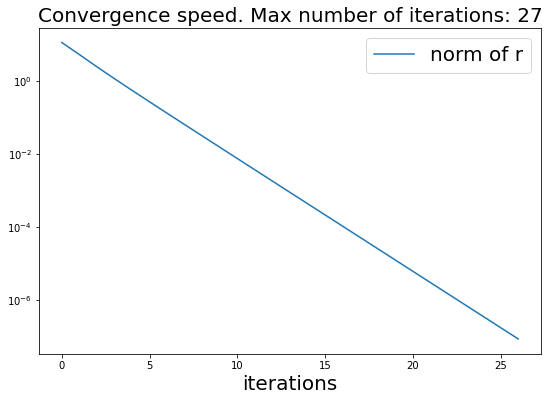

In [ ]:
from numpy.linalg import norm

def alternating_projection_SDP(A, b, max_its=200):
    """
    Compute a feasible point for SDP constraints using alternating projection algorithm.
    Return an (almost) feasible point, together with residuals for the constraints.
    """
    #check dimensions
    if np.shape(A)[0] != np.shape(b)[0] or np.shape(A)[1] !=np.shape(A)[2] :
        print('There is a problem of dimension.')
        
    k = np.shape(A)[0] # number of conditions
    n = np.shape(A)[1] # size of each matrix Ai
    
     #check if A is symmetric
    bool_A_sym =1 #initialization
    for i in range(k):
        bool_A_sym = bool_A_sym*np.isclose(A[i,:,:],A[i,:,:].T, rtol=10**-4).all()
    if not bool_A_sym:
        print('A is not symmetric.')

    
    #initializations 
    nb_iter = 0
    eps = 10**-16
    stop_criterion = 10**-7

    X = np.random.rand(n, n)
    X = np.tril(X) + np.tril(X, -1).T # make X symmetric
    #check if X is symmetric
    #print((X.T ==X).all())
    
    #initialize residuals 
    residuals = [1] #just in order to enter in the while, then will not be taken in account

    # set boolean conditions
    hyperp_cond = np.isclose(np.tensordot(A, X),b, rtol=eps)    
    cone_cond = np.linalg.eigh(X)[0][0]>=0
    cond = np.concatenate((hyperp_cond.reshape(k,1), np.array(cone_cond).reshape(1,1)))
    
    # decide stopping criterion : all boolean conditions should be True (0) or residual < 10**-7 (1)
    bool_stop_crit = 1
    
    if bool_stop_crit ==0:
        while not(all(cond)) and nb_iter<max_its :
            print('Iteration number: ',nb_iter)
            nb_iter += 1
            
            #projecting onto hyperplanes
            for i in np.where(hyperp_cond==0)[0]:
                Ai = A[i,:,:]
                X -= ((np.tensordot(Ai,X)-b[i])/ np.tensordot(Ai,Ai))*Ai
                
            #projecting onto positive definite cone    
            for i in np.where(cone_cond==0)[0]:
                eig_val, eig_vect = np.linalg.eigh(X) #compute eigenvalue decomposition
                pos_eig = [np.maximum(0,eig_val[j])for j in range((eig_val.shape[0]))]
                X = np.dot(np.dot(eig_vect,np.diag(pos_eig)),eig_vect.T)
            
            #uptade boolean of conditions 
            hyperp_cond = np.isclose(np.tensordot(A, X),b, rtol=eps)    
            cone_cond = eig_val[0]>=0
            cond = np.concatenate((hyperp_cond.reshape(k,1), np.array(cone_cond).reshape(1,1)))
            print('Boolean of conditions:',cond.T)
            
            # increment of residual list
            residuals.append(norm(np.tensordot(A, X)-b))
            print('Norm of current residual :', residuals[-1])
            
    elif bool_stop_crit ==1:
        while residuals[-1]>stop_criterion and nb_iter<max_its :
            print('Iteration number: ',nb_iter)
            nb_iter += 1
            
            #projecting onto hyperplanes
            for i in np.where(hyperp_cond==0)[0]:
                Ai = A[i,:,:]
                X -= ((np.tensordot(Ai,X)-b[i])/ np.tensordot(Ai,Ai))*Ai
   
            #projecting onto positive definite cone    
            for i in np.where(cone_cond==0)[0]:
                eig_val, eig_vect = np.linalg.eigh(X) #compute eigenvalue decomposition
                pos_eig = [np.maximum(0,eig_val[j])for j in range((eig_val.shape[0]))]
                X = np.dot(np.dot(eig_vect,np.diag(pos_eig)),eig_vect.T)
            
            #uptade boolean of conditions 
            hyperp_cond = np.isclose(np.tensordot(A, X),b, rtol=eps)    
            cone_cond = eig_val[0]>=0
            cond = np.concatenate((hyperp_cond.reshape(k,1), np.array(cone_cond).reshape(1,1)))
            #print('Boolean of conditions:',cond.T)
            
            # increment of residual list
            residuals.append(norm(np.tensordot(A, X)-b))
            print('Norm of current residual :', residuals[-1])
            
    #check if X is still symmetric 
    #np.isclose(X,X.T, rtol=10**-4) 
      
    return X, residuals[1:]


n = 10
k = 5

# Create array of random symmetric matrices
A = np.random.normal(size=(k, n, n))
A = A + np.transpose(A, (0, 2, 1))
b = np.random.normal(size=k)

X, residuals = alternating_projection_SDP(A, b)

# Plot how the residuals change with each iteration
real_max_iter = len(residuals)
plt.title('Convergence speed. Max number of iterations: %i'%real_max_iter , fontsize = 20)
plt.yscale('log')
plt.xlabel("iterations", fontsize = 20)
plt.plot(residuals, label ='norm of r')
plt.legend(prop={"size":20})

## Part 2: Frank-Wolfe method and LASSO

After finding a feasible point, there are many algorithms to solve a convex problem. The algorithm we will consider is the [Frank-Wolfe method](https://en.wikipedia.org/wiki/Frank%E2%80%93Wolfe_algorithm). The idea is that optimizing a _linear_ function over a convex domain is relatively simple, so at each step of the algorithm we linearize our objective and do a step towards the optimum of the linearized function. That is, if we have a convex function $f\colon\Omega \to \mathbb R$, an we start with some point $\beta_0\in \Omega$. Then in an iterative procedure we define $\beta_{k+1}\in\Omega$ given $\beta_k\in\Omega$ at step $k$ by first solving the linear problem
$$
   \alpha_k =\operatorname{argmin}_{\alpha \in\Omega}\alpha^\top\nabla f(\beta_k).
$$

Then we update $\beta_{k}$ by setting
$$
    \beta_{k+1} = \beta_k + t_k(\alpha_k-\beta_k).
$$

with $t_k$ a suitably chosen stepsize. Because of the optimality conditions, $\alpha_k-\beta_k$ is then a [descent direction](https://en.wikipedia.org/wiki/Descent_direction), so the function is gauranteed to decrease along this line. Note that for $t=1$ we obtain the point $\alpha_k$, and therefore by convexity any value $t_k\in[0,1]$ is a valid stepsize (i.e., one such that $\beta_{k+1}\in\Omega$). For many problems we can compute the optimal value for $t_k$, but if not then we can use a constant stepsize or a line search method such as [Armijo backtracking](https://en.wikipedia.org/wiki/Backtracking_line_search).

The largest advantage of the Frank-Wolfe method is that it is versatile and simple to implement. We can use it so long as we can compute the gradient of a function cheaply, and use a linear programming solver as a black box. Its main disadvantage is that it has sublinear convergence speed, and for most convex problems there are more efficient specialized solvers.

The Frank-Wolfe method is similar to the projected gradient descent method, but there instead we take an _unconstrained_ linear step in the direction of the gradient, and then project back onto the constraint set. For many constraint sets there is no efficient way to project onto the set, in which case the Frank-Wolfe method can be cheaper.


We will apply the Frank-Wolfe method to the [LASSO problem](https://en.wikipedia.org/wiki/Lasso_(statistics)). This is least-squares regression, with an $\ell_1$-norm constraint on the parameters. That is, given $N$ (mean centered) data points $X=(x_1,\dots,x_n)^\top\in \mathbb R^{N\times n}$ and $y=(y_1,\dots,y_n)\in \mathbb R^N$ we consider the following problem for $s\in\mathbb R$ fixed:
$$
\begin{array}{ll}
\text{minimize} & \|y-X\beta\|^2_2\\
\text{subject to} & \|\beta\|_1=\sum_{i}|\beta_i| \leq s
\end{array}
$$

This problem is convex, and we will solve it using the Frank-Wolfe method.

---

> Implement the Frank-Wolfe method to solve the Lasso problem. 

---

Tips:

- Finding a feasible point for this problem is very easy.

- Find an explicit expression for the gradient $\nabla f(\beta_k)$ at a point $\beta_k$. Use this to formulate the linear problem $\alpha_k = \operatorname{argmin}_{\|\alpha\|_1\leq s}\alpha^\top \nabla f(\beta_k)$, and solve it using CVXPY.

- For this problem we can do an _exact linesearch_. That is, there is a simple formula for the optimal stepsize $t_k$. Find this by first solving the problem $t_k=\operatorname{argmin}_{t\in[0,1]}\|y-X(\beta_k+t(\alpha_k-\beta_k))\|$.

- You can use the stepsize as a stopping criterion. If the stepsize $t_k$ is very small, then we have reached the boundary of domain, and the search direction was close to orthogonal to this boundary.

Iteration number:  1
Stepsize : 0.3093911097811084
Iteration number:  2
Stepsize : 0.047954362907251004
Iteration number:  3
Stepsize : 0.053646254541566435
Iteration number:  4
Stepsize : 0.0947578601461076
Iteration number:  5
Stepsize : 0.035247943788891734
Iteration number:  6
Stepsize : 0.02201842750907465
Iteration number:  7
Stepsize : 0.010447318789124168
Iteration number:  8
Stepsize : 0.015808806324590603
Iteration number:  9
Stepsize : 0.007885890527175272
Iteration number:  10
Stepsize : 0.012078334717381824
Iteration number:  11
Stepsize : 0.006060058185477624
Iteration number:  12
Stepsize : 0.008730208124839215
Iteration number:  13
Stepsize : 0.015038544803079104
Iteration number:  14
Stepsize : 0.0053034748422907665
Iteration number:  15
Stepsize : 0.008220267821354377
Iteration number:  16
Stepsize : 0.004148143130471693
Iteration number:  17
Stepsize : 0.005354688293247264
Iteration number:  18
Stepsize : 0.010041806312933202
Iteration number:  19
Stepsize : 0.003690

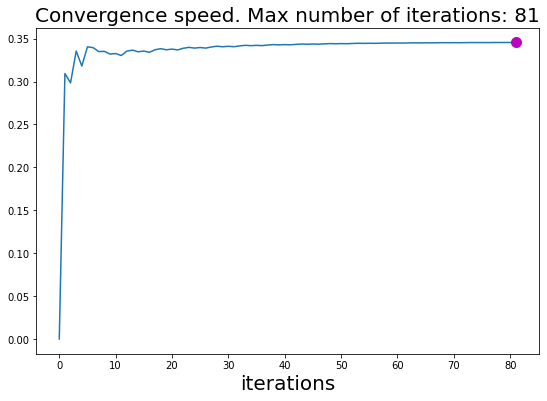

In [ ]:
N = 5  # number of data points
n = 3  # dimension

# Generate random ground-truth data
X = np.random.normal(size=(N, n))
beta_true = np.random.normal(size=n)

# make true Beta inside constraint set. If you comment out this line
# then the estimated beta is probably no longer equal to `beta_true`.
# You should experiment with this. Also experiment with the value of `s`.
beta_true /= 2 * np.linalg.norm(beta_true, ord=1)
X = X - np.mean(X, axis=0)
y = X @ beta_true


def FW_LASSO(X, y, s=1, max_its=1000):
    """Solve the LASSO problem using Frank-Wolfe.

    Input is mean-centered data X,y, the value of `s`,
    and the maximum number of iterations."""
        #check dimensions
    if np.shape(X)[0] != np.shape(y)[0] or len(np.shape(s)) !=0:
        print('There is a problem of dimension.')
        
    #initialisation
    t = 1
    beta = np.zeros(X.shape[1]) #feasible point 
    nb_iter = 0
    stop_criterion = 10**-4
    BETAS = [0]
    
    while t>stop_criterion and nb_iter<max_its :
        nb_iter += 1
        print('Iteration number: ',nb_iter)
        
        #compute gradient
        grad = LASSO_grad(X, y, beta)
        
        #compute alpha
        direction = min_linear_problem(grad, s)
        
        #compute the stepsize
        t = opt_linesearch(X, y, beta, direction)
        
        if norm(beta + t*(direction - beta),ord=1)>s:
            print('The new beta is escaping the constraint set.')    
        
        #update beta    
        beta = beta + t*(direction - beta)
        BETAS.append(norm(beta))
        
    return beta, BETAS

def LASSO_grad(X, y, beta):
    """Return the gradient of the LASSO problem for data X,y at point `beta`"""
    return np.dot(2*X.T,np.dot(X,beta)-y)
    
def min_linear_problem(grad, s):
    """Find the minimum of the linear problem.

    Depends on the LASSO gradient and the value of `s` determining
    the constraint set."""
    alp = cp.Variable(grad.size)
    objective = cp.Minimize(alp*grad)
    constraints = [cp.norm(alp,1) <=s]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return alp.value

def opt_linesearch(X, y, beta, direction):
    """Return the result of exact linesearch.
    That is, the best possible choice of stepsize `t`. Make sure
    that this doesn't escape the constraint set."""
    
    temp = np.dot(X, direction -beta)
    t = (np.dot(y.T,temp)- np.dot(beta.T,np.dot(X.T,temp))) / (np.dot(temp.T,temp))
    print('Stepsize :',t)
    if  t>1:
        print("Error : t is not between 0 and 1")
    return t

# Compute beta from data. Compare to ground truth
beta, BETAS = FW_LASSO(X, y)
print('Difference between True beta and the approximate one', beta - beta_true)

# Plot how the residuals change with each iteration
real_max_iter = len(BETAS)-1
plt.title('Convergence speed. Max number of iterations: %i'%real_max_iter , fontsize = 20)
plt.xlabel("iterations", fontsize = 20)
plt.plot(BETAS)
plt.plot(real_max_iter, norm(beta), "om", markersize=10)